In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

Import OSNIR Dataset and shuffle data

In [19]:
# import OSNIR dataset
df = pd.read_csv('../Data/OSNIR_values_extendedv3_new datasetbcsv.csv')
# shuffling rows of OSNIR dataframe and reset indexes
df = df.sample(frac=1)
df.reset_index(inplace=True, drop=True)

Preview of first 5 samples

In [20]:
df.head()

,OSNIRnumerical(dB),Ns,Pch(dBm),L(km),B(GHz),GB(GHz),Nch
0,9.571108,27,2,100,25.0,0.0,9
1,10.510504,17,-6,100,25.0,0.0,9
2,11.887890,25,-2,100,25.0,0.0,9
3,29.547655,8,-7,10,25.0,0.0,9
4,26.722386,16,-4,10,25.0,0.0,9


1800 values for training (0,1800-1)\
600 values for validation (1800,2400-1)\
600 values for testing (2400,3000-1)

In [21]:
data = np.array(df)

In [22]:
# input x aka Ns, Pch, L, B, GB, Nch values
x_train = data[0:1800-1, 1:7]
x_valid = data[1800:2400-1, 1:7]
x_test = data[2400:3000-1, 1:7]

# output y aka OSNIR values
y_train = data[0:1800-1, 0]
y_valid = data[1800:2400-1, 0]
y_test = data[2400:3000-1, 0]

In [23]:
x_train

array([[ 27. ,   2. , 100. ,  25. ,   0. ,   9. ],
       [ 17. ,  -6. , 100. ,  25. ,   0. ,   9. ],
       [ 25. ,  -2. , 100. ,  25. ,   0. ,   9. ],
       ...,
       [ 44. ,   0. ,  50. ,  25. ,   0. ,   3. ],
       [ 38. ,  -3. ,  50. ,  12.5,   0. ,   9. ],
       [ 42. ,  -3. ,  50. ,  25. ,   0. ,   3. ]])

### Create the Neural Network
1 Input layer, 2 hidden layers (32 neurons each) and 1 Output Layer

In [24]:
model = keras.Sequential([
    keras.layers.Dense(32, input_shape=(6,), activation='relu'),  # first hidden layer
    keras.layers.Dense(32, activation='relu'),  # second hidden layer
    keras.layers.Dense(1, activation='relu') # output layer (3)
])

Early hault of training if loss has not improved in 50 epochs in validation set

In [25]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=50)

Adam Optimizer, Mean Square Error Loss

In [26]:
model.compile(optimizer='adam',
              loss='mse'
              )

Fitting the model, run for 500 epochs

In [27]:
model.fit(x_train, y_train,
          validation_data=(x_valid,y_valid), 
          epochs=500, 
          #batch_size=25,
          callbacks=[early_stop],
          batch_size=32, verbose=1)

Epoch 1/500
57/57 [==============================] - 1s 6ms/step - loss: 161.8584 - val_loss: 75.8157
Epoch 2/500
57/57 [==============================] - 0s 2ms/step - loss: 58.5321 - val_loss: 48.7175
Epoch 3/500
57/57 [==============================] - 0s 2ms/step - loss: 44.9288 - val_loss: 45.3242
Epoch 4/500
57/57 [==============================] - 0s 2ms/step - loss: 38.4893 - val_loss: 36.4522
Epoch 5/500
57/57 [==============================] - 0s 2ms/step - loss: 35.9346 - val_loss: 32.0691
Epoch 6/500
57/57 [==============================] - 0s 2ms/step - loss: 32.1995 - val_loss: 29.5834
Epoch 7/500
57/57 [==============================] - 0s 2ms/step - loss: 29.6249 - val_loss: 28.5624
Epoch 8/500
57/57 [==============================] - 0s 2ms/step - loss: 29.3763 - val_loss: 28.1262
Epoch 9/500
57/57 [==============================] - 0s 2ms/step - loss: 27.1199 - val_loss: 25.6739
Epoch 10/500
57/57 [==============================] - 0s 2ms/step - loss: 26.4373 - val_lo

In [28]:
OSNIR_num = data[:3000-1,0]
Input_num = data[:3000-1,1:7]

In [29]:
OSNIR_est = (model.predict(Input_num)) 

94/94 [==============================] - 0s 1ms/step


In [30]:
for i in range(10):
    print('%s => %f (expected %f)' % (Input_num[i].tolist(), OSNIR_est[i], OSNIR_num[i] ))

[27.0, 2.0, 100.0, 25.0, 0.0, 9.0] => 9.811952 (expected 9.571108)
[17.0, -6.0, 100.0, 25.0, 0.0, 9.0] => 10.540276 (expected 10.510504)
[25.0, -2.0, 100.0, 25.0, 0.0, 9.0] => 11.606930 (expected 11.887890)
[8.0, -7.0, 10.0, 25.0, 0.0, 9.0] => 29.434780 (expected 29.547655)
[16.0, -4.0, 10.0, 25.0, 0.0, 9.0] => 26.980402 (expected 26.722386)
[14.0, -3.0, 100.0, 12.5, 0.0, 9.0] => 15.279263 (expected 15.298383)
[25.0, -7.0, 50.0, 25.0, 0.0, 3.0] => 18.091705 (expected 17.838533)
[44.0, -4.0, 50.0, 25.0, 0.0, 3.0] => 17.524139 (expected 17.217194)
[14.0, -5.0, 10.0, 50.0, 0.0, 9.0] => 26.773251 (expected 27.044128)
[31.0, -3.0, 100.0, 25.0, 0.0, 9.0] => 10.277576 (expected 10.541594)


Calculate difference between actual OSNIR and predicted OSNIR (in dB)

In [31]:
Mism = np.zeros(3000-1)
for i in range(3000-1):
    Mism[i] = OSNIR_num[i] - OSNIR_est[i]

In [32]:
pred_df = pd.DataFrame({"Actual OSNIR (dB)" : OSNIR_num.tolist(), "Predicted OSNIR (dB)" : OSNIR_est.tolist(), "Difference (dB)" : Mism.tolist()})
pred_df.to_csv("OSNIR_Prediction.csv",index=False)

(array([0.        , 0.        , 0.        , 0.00066689, 0.        ,
        0.        , 0.00033344, 0.00100033, 0.00100033, 0.00066689,
        0.00133378, 0.00400133, 0.00633545, 0.02634211, 0.05335112,
        0.12037346, 0.18906302, 0.21273758, 0.19373124, 0.11437146,
        0.04801601, 0.01867289, 0.00466822, 0.003001  , 0.00033344,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([-3.        , -2.82857143, -2.65714286, -2.48571429, -2.31428571,
        -2.14285714, -1.97142857, -1.8       , -1.62857143, -1.45714286,
        -1.28571429, -1.11428571, -0.94285714, -0.77142857, -0.6       ,
        -0.42857143, -0.25714286, -0.08571429,  0.08571429,  0.25714286,
         0.42857143,  0.6       ,  0.77142857,  0.94285714,  1.11428571,
         1.28571429,  1.45714286,  1.62857143,  1.8       ,  1.97142857,
         2.14285714,  2.31428571,  2.48571429,  2.65714286,  2.82857143,
         3.

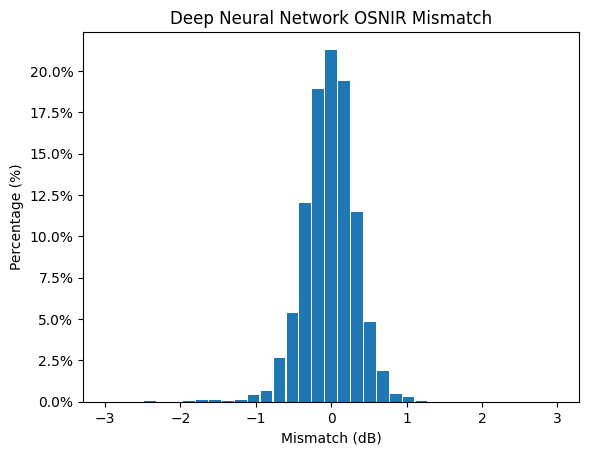

In [35]:
plt.title('Deep Neural Network OSNIR Mismatch')
plt.xlabel('Mismatch (dB)')
plt.ylabel('Percentage (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.hist(Mism, range=(-3,3), rwidth=0.9, bins=35, weights=np.ones(len(Mism))/len(Mism))